In [1]:
# import necessary libraries
import pandas as pd

In [2]:
data = pd.read_csv('df_merged_weekly_all.csv', index_col=0)
data['date'] = pd.to_datetime(data['date'])
data.reset_index(inplace=True)
data

,level_0,index,week,date,cases,temperature,pressure,humidity,precipitation
0,0,0,2016-1,2016-01-10,19.0,303.437143,1012.285714,71.428571,1.02
1,1,1,2016-2,2016-01-17,23.0,303.908571,1012.857143,65.571429,0.00
2,2,2,2016-3,2016-01-24,31.0,302.251429,1014.428571,76.857143,32.85
3,3,3,2016-4,2016-01-31,26.0,302.778571,1011.142857,75.142857,17.05
4,4,4,2016-5,2016-02-07,10.0,303.285714,1012.428571,70.571429,3.70
...,...,...,...,...,...,...,...,...,...
393,393,135,2024-32,2024-08-05,226.0,302.210000,1009.000000,75.000000,8.78
394,394,136,2024-33,2024-08-12,205.0,303.050000,1007.000000,70.000000,4.91
395,395,137,2024-34,2024-08-19,209.0,303.620000,1009.000000,67.000000,11.63
396,396,138,2024-35,2024-08-26,162.0,302.490000,1008.000000,73.000000,10.55


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   level_0        398 non-null    int64         
 1   index          398 non-null    int64         
 2   week           398 non-null    object        
 3   date           398 non-null    datetime64[ns]
 4   cases          398 non-null    float64       
 5   temperature    398 non-null    float64       
 6   pressure       398 non-null    float64       
 7   humidity       398 non-null    float64       
 8   precipitation  398 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 28.1+ KB


# Columns
| column        | description                             | type     |
|---------------|-----------------------------------------|----------|
| week          | week corresponding to the specific year | datetime | 
| dt            | specific date                           | datetime |
| Cases         | Dengue Cases                            | integer  |
| temp          | Average temperature in the given week   | numeric  |
| feels_like    | Average feels_life in the given week    | numeric  |
| pressure      | Average pressure in the given week      | numeric  |
| humidity      | Average humidity in the given week      | numeric  |
| precipitation | Total precipitation in the given week   | numeric  |

## Training data
Data used to be trained range from 2022 to 2023

## Testing data
Data used to be tested is 2024 (also used for training)

In [ ]:
# Training the rf model
# defining a function for general looping of n-week aheads
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def train_rf(data, features, target, date_col, n_ahead):
    # Select relevant columns
    rel_col = features + [target] + [date_col]
    data = data[rel_col]
    
    # Getting the first and last index for the year 2024
    first_2024 = data[data[date_col].dt.year == 2023].index[0]  # First index of 2024
    last_2024 = data[data[date_col].dt.year == 2024].index[-1]  # Last index of 2024
    
    first_2024subn = first_2024 - n_ahead # Subtract n_ahead weeks from first date of 2024
    last_2024subn = last_2024 - n_ahead  # Subtract n_ahead weeks from last date of 2024
    
    # Define lags
    env_lags = [1,2,3,4]   #2-week lag for environment features
    cases_lag = range(1, 12)  # 1 to 11 week lags for target variable
    
    # Create lagged features for environment and target variables
    for lag in env_lags:
        for feature in features:
            data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
    
    for lag in cases_lag:
        data[f'{target}_lag_{lag}'] = data[target].shift(lag)
    
    # Remove any rows with missing values due to lagging
    data = data.dropna()
    
    # Initialize list for storing predictions
    predict_data = []
    actual_data = []
    # Loop through data to get n-week ahead prediction
    index_begin = first_2024subn
    index_end = last_2024subn
    while index_begin <= index_end:
        rf = RandomForestRegressor(n_estimators=300)  # RandomForestRegressor with 100 estimators (can be tuned)
        
        # Split data into training and testing sets
        train_data = data[data.index <= index_begin]  # All rows up to index_begin
        test_data = data.iloc[data.index.get_loc(index_begin):data.index.get_loc(index_begin) + n_ahead]  # Next n_ahead rows
        X_train = train_data.drop(columns=[target, date_col])  # Drop target and date column for training data
        y_train = train_data[target]
        X_test = test_data.drop(columns=[target, date_col])  # Drop target and date column for test data
        y_test = test_data[target]
        
        # Fit the RandomForest model
        rf.fit(X_train, y_train)
        
        # Get the last prediction (n-week ahead prediction)
        predict_data.append(rf.predict(X_test)[-1])
        actual_data.append(y_test.iloc[-1])
        # Increment the index to the next week
        index_begin += 1
    MAE = mean_absolute_error(actual_data, predict_data)
    return predict_data, MAE

In [29]:
# Perform Initial Testing
target="cases"
features=["temperature","humidity","precipitation"]
date = 'date'
prediction_1_week, MAE_1_week = train_rf(data, features, target, date, 1)
prediction_4_week, MAE_4_week = train_rf(data, features, target, date, 4)
prediction_12_week, MAE_12_week = train_rf(data, features, target, date, 12)

In [30]:
print(f'The Mean Absolute Error of the 1-Week Ahead Model is {MAE_1_week}')
print(f'The Mean Absolute Error of the 4-Week Ahead Model is {MAE_4_week}')
print(f'The Mean Absolute Error of the 12-Week Ahead Model is {MAE_12_week}')

The Mean Absolute Error of the 1-Week Ahead Model is 3.2783333333333333
The Mean Absolute Error of the 4-Week Ahead Model is 8.935568181818182
The Mean Absolute Error of the 12-Week Ahead Model is 8.662348484848485


In [203]:
prediction_1_week[:5]

[np.float64(19.88),
 np.float64(17.99),
 np.float64(16.11),
 np.float64(20.52),
 np.float64(21.62)]

In [204]:
prediction_4_week[:5]

[np.float64(29.92),
 np.float64(27.83),
 np.float64(13.77),
 np.float64(13.2),
 np.float64(21.46)]

# Visualization

In [34]:
import matplotlib.pyplot as plt
first_2024 = int((data['date'].dt.year==2023).idxmax())
last_2024 = int(data.loc[data['date'].dt.year == 2024].index[-1])
date = data.loc[first_2024:last_2024]['date']

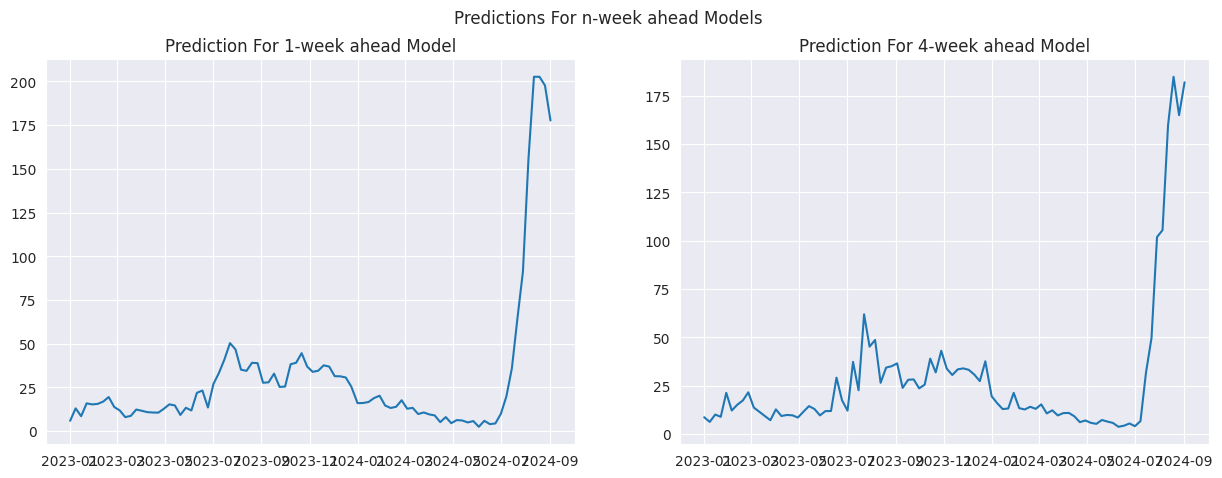

In [35]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(date,prediction_1_week)
ax[0].set_title('Prediction For 1-week ahead Model')
ax[1].plot(date,prediction_4_week)
ax[1].set_title('Prediction For 4-week ahead Model')
plt.suptitle('Predictions For n-week ahead Models')
plt.show()

Text(0.5, 1.0, 'Actual Cases')

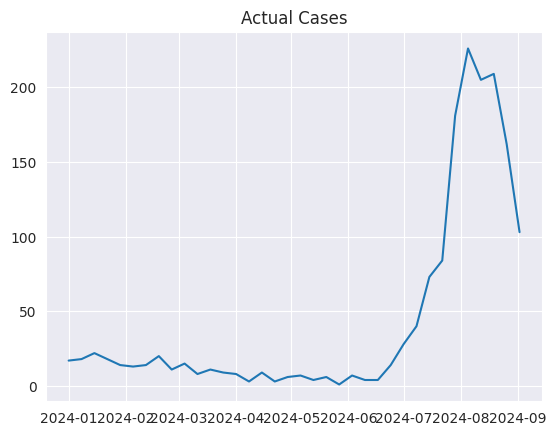

In [36]:
actual_2024 = data[data['date'].dt.year == 2024]
plt.plot(actual_2024['date'], actual_2024['cases'])
plt.plot()
plt.title('Actual Cases')

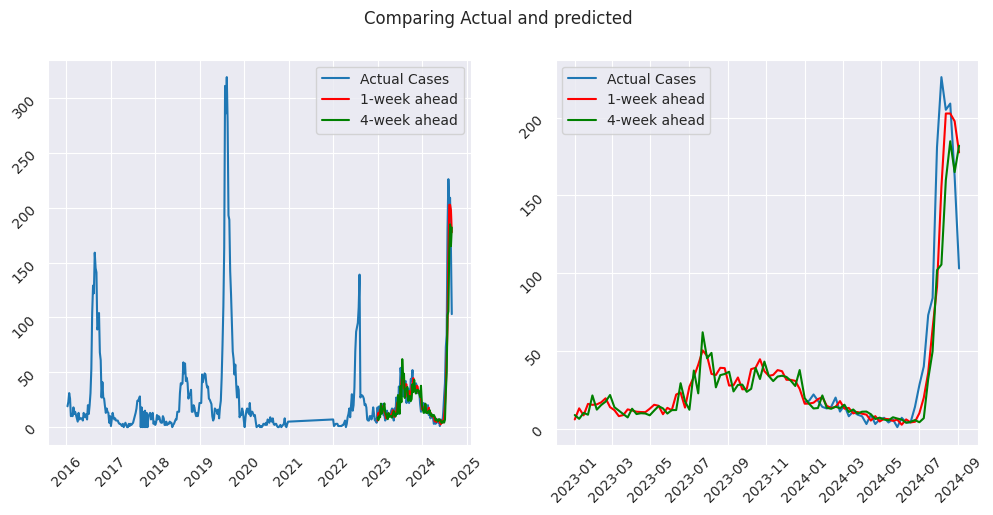

In [38]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(data['date'], data['cases'], label = 'Actual Cases')
ax[0].plot(date, prediction_1_week, color = 'red', label = '1-week ahead')
ax[0].plot(date, prediction_4_week, color = 'green', label = '4-week ahead')
ax[0].tick_params(labelrotation=45)
ax[0].legend()
ax[1].plot(actual_2024['date'], actual_2024['cases'], label = 'Actual Cases')
ax[1].plot(date, prediction_1_week, color = 'red', label = '1-week ahead')
ax[1].plot(date, prediction_4_week, color = 'green', label = '4-week ahead')
ax[1].tick_params(labelrotation=45)
ax[1].legend()
plt.suptitle('Comparing Actual and predicted')
plt.show()

In [39]:
rf

NameError: name 'rf' is not defined